In [50]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import scienceplots
import shap
import xgboost as xgb

import events_package.utils as utils
from events_package.Experiment import Experiment
from events_package.config import FIVE_LAYERS
from events_package.input_getters import get_Y_1, get_Y_2, get_X_5
from events_package.BinFunction import BinFunction

In [51]:
Experiment.__version__

'5.0'

# 1. Importing Single Particle Data

## 1.1 Electrons

In [52]:
# importing data
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Electron\Parquet\1m_electron_pq_3"
)

electrons = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
electrons.length

444840

In [53]:
electrons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434998
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434998


## 1.2 Photons

In [54]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Photon\Parquet\1m_photon_pq"
)

photons = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
photons.length

444142

In [55]:
photons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434870
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434870


## 1.3 Neutral Pions

In [56]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiZero\Parquet\pq_pi0_2"
)

pi0 = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
pi0.length

412856

In [57]:
pi0.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 391483
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 391483


## 1.4 Charged Pions

In [58]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiPlusMinus\Parquet\pq_piplusminus_2"
)

pi_char = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
pi_char.length

357554

In [59]:
pi_char.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 330809
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 330803


## 1.5 Combining Different Particle Data

In [60]:
# add types to allow for identification later
electrons.add_physics_object_type(typ="electron")
photons.add_physics_object_type(typ="photon")
pi0.add_physics_object_type(typ="pi0")
pi_char.add_physics_object_type(typ="pi_char")

In [61]:
experiment = electrons + photons + pi0 + pi_char

# all previous datasets have already been denoisified, duplicates were removed, no need to do it now
# in fact, doing it would delete some good events
experiment.shuffle_dataset(repeats=11)
print(experiment.length)

1592154


In [62]:
experiment.train_test_split(get_X=get_X_5, get_Y=get_Y_1, test_size=0.2)
X_train = experiment.X_train

In [63]:
utils.calculate_confidence_range(experiment.X_train.T[1], cl=99.8)

(-1.4115977, 1.4897593)

In [64]:
utils.calculate_confidence_interval(experiment.X_train.T[1], cl=99.8)

1.4506785

In [65]:
psb_mapping = utils.create_mapping(np.unique(np.sort(experiment.psb_eta.values)))
emb1_mapping = utils.create_mapping(np.unique(np.sort(experiment.emb1_eta.values)))
emb2_mapping = utils.create_mapping(np.unique(np.sort(experiment.emb2_eta.values)))
emb3_mapping = utils.create_mapping(np.unique(np.sort(experiment.emb3_eta.values)))
hab1_mapping = utils.create_mapping(np.unique(np.sort(experiment.hab1_eta.values)))

In [66]:
mappings = {
    "psb_mapping": psb_mapping,
    "emb1_mapping": emb1_mapping,
    "emb2_mapping": emb2_mapping,
    "emb3_mapping": emb3_mapping,
    "hab1_mapping": hab1_mapping,
}

In [67]:
current_directory = os.getcwd()
quantisations_directory = os.path.join(current_directory, "..", "quantisations")

# ensure that the "quantisations" directory exists, if not, create it
if not os.path.exists(quantisations_directory):
    os.makedirs(quantisations_directory)

# full path
pickle_path = os.path.join(quantisations_directory, "mappings.pkl")

# save the mappings dictionary to a pickle file
with open(pickle_path, "wb") as f:
    pickle.dump(mappings, f)

In [99]:
bin_q = 256

bin_functions = {}

# Loop to create and store the instances
for i in range(5, 22):  # Assuming X_train_3.T[5] to X_train_3.T[21]
    cl = 99.8
    if i in [9, 11, 16, 18, 20]:
        cl = 98

    bin_functions[f"q{i}"] = BinFunction(X_train.T[i], bins=bin_q, cl=cl)

pickle_path = os.path.join(quantisations_directory, "bin_functions.pkl")

# Save the bin_functions object to a pickle file
with open(pickle_path, "wb") as f:
    pickle.dump(bin_functions, f)

In [100]:
diff1_q = bin_functions["q5"]
diff2_q = bin_functions["q6"]
diff3_q = bin_functions["q7"]
diff4_q = bin_functions["q8"]


q9 = bin_functions["q9"]  # psb (4)
q10 = bin_functions["q10"]  # psn (5) - psb (3)
q11 = bin_functions["q11"]  # emb1 (8)
q12 = bin_functions["q12"]  # emb1 (9) - emb1 (7)
q13 = bin_functions["q13"]  # emb1(10) - emb1(6)
q14 = bin_functions["q14"]  # emb1(11) - emb1(5)
q15 = bin_functions["q15"]  # emb1(12) - emb1(4)
q16 = bin_functions["q16"]  # emb2(4)
q17 = bin_functions["q17"]  # emb2(5) - emb2(3)
q18 = bin_functions["q18"]  # emb3(4)
q19 = bin_functions["q19"]  # emb3(5) - emb3(3)
q20 = bin_functions["q20"]  # hab1(4)
q21 = bin_functions["q21"]  # hab1(5) - hab1(3)

In [101]:
def get_X_5_quant(dataframe):
    """Quantising etas and ata diffs."""

    s = dataframe.shape[0]  # number of rows (events)

    psb_info = np.sum(dataframe["psb_cells"].values.reshape(s, 7, 9), axis=1)
    emb1_info = np.sum(dataframe["emb1_cells"].values.reshape(s, 3, 17), axis=1)
    emb2_info = np.sum(dataframe["emb2_cells"].values.reshape(s, 7, 9), axis=1)
    emb3_info = np.sum(dataframe["emb3_cells"].values.reshape(s, 7, 9), axis=1)
    hab1_info = np.sum(dataframe["hab1_cells"].values.reshape(s, 7, 9), axis=1)

    psb_tot = np.sum(psb_info, axis=1)
    emb1_tot = np.sum(emb1_info, axis=1)
    emb2_tot = np.sum(emb2_info, axis=1)
    emb3_tot = np.sum(emb3_info, axis=1)
    hab1_tot = np.sum(hab1_info, axis=1)
    en_tot = psb_tot + emb1_tot + emb2_tot + emb3_tot + hab1_tot

    psb_info = utils.fold_list_2d(psb_info) / en_tot[:, np.newaxis]
    emb1_info = utils.fold_list_2d(emb1_info) / en_tot[:, np.newaxis]
    emb2_info = utils.fold_list_2d(emb2_info) / en_tot[:, np.newaxis]
    emb3_info = utils.fold_list_2d(emb3_info) / en_tot[:, np.newaxis]
    hab1_info = utils.fold_list_2d(hab1_info) / en_tot[:, np.newaxis]

    v9 = psb_info.T[0]
    v10 = psb_info.T[1]
    v11 = emb1_info.T[0]
    v12 = emb1_info.T[1]
    v13 = emb1_info.T[2]
    v14 = emb1_info.T[3]
    v15 = emb1_info.T[4]
    v16 = emb2_info.T[0]
    v17 = emb2_info.T[1]
    v18 = emb3_info.T[0]
    v19 = emb3_info.T[1]

    v20 = hab1_info.T[0]
    v21 = hab1_info.T[1]

    in9 = np.array([q9.bin_function(val) for val in v9])
    in10 = np.array([q10.bin_function(val) for val in v10])
    in11 = np.array([q11.bin_function(val) for val in v11])
    in12 = np.array([q12.bin_function(val) for val in v12])
    in13 = np.array([q13.bin_function(val) for val in v13])
    in14 = np.array([q14.bin_function(val) for val in v14])
    in15 = np.array([q15.bin_function(val) for val in v15])
    in16 = np.array([q16.bin_function(val) for val in v16])
    in17 = np.array([q17.bin_function(val) for val in v17])
    in18 = np.array([q18.bin_function(val) for val in v18])
    in19 = np.array([q19.bin_function(val) for val in v19])

    in20 = np.array([q20.bin_function(val) for val in v20])
    in21 = np.array([q21.bin_function(val) for val in v21])

    # eta mappings
    psb_eta_info = np.array([psb_mapping[val] for val in dataframe.psb_eta.values])
    emb1_eta_info = np.array([emb1_mapping[val] for val in dataframe.emb1_eta.values])
    emb2_eta_info = np.array([emb2_mapping[val] for val in dataframe.emb2_eta.values])
    emb3_eta_info = np.array([emb3_mapping[val] for val in dataframe.emb3_eta.values])
    hab1_eta_info = np.array([hab1_mapping[val] for val in dataframe.hab1_eta.values])

    diffs_exact_1 = dataframe.psb_eta.values.astype(
        "float16"
    ) - dataframe.emb1_eta.values.astype("float16")
    diffs_exact_2 = dataframe.emb1_eta.values.astype(
        "float16"
    ) - dataframe.emb2_eta.values.astype("float16")
    diffs_exact_3 = dataframe.emb2_eta.values.astype(
        "float16"
    ) - dataframe.emb3_eta.values.astype("float16")
    diffs_exact_4 = dataframe.emb3_eta.values.astype(
        "float16"
    ) - dataframe.hab1_eta.values.astype("float16")

    diff1_info = np.array([diff1_q.bin_function(val) for val in diffs_exact_1])
    diff2_info = np.array([diff2_q.bin_function(val) for val in diffs_exact_2])
    diff3_info = np.array([diff3_q.bin_function(val) for val in diffs_exact_3])
    diff4_info = np.array([diff4_q.bin_function(val) for val in diffs_exact_4])

    X1 = np.hstack(
        (
            psb_eta_info.reshape(-1, 1).astype("int16"),
            emb1_eta_info.reshape(-1, 1).astype("int16"),
            emb2_eta_info.reshape(-1, 1).astype("int16"),
            emb3_eta_info.reshape(-1, 1).astype("int16"),
            hab1_eta_info.reshape(-1, 1).astype("int16"),
            #########################################
            diff1_info.reshape(-1, 1).astype("int16"),
            diff2_info.reshape(-1, 1).astype("int16"),
            diff3_info.reshape(-1, 1).astype("int16"),
            diff4_info.reshape(-1, 1).astype("int16"),
            ###########################################
            in9.reshape(-1, 1).astype("int16"),
            in10.reshape(-1, 1).astype("int16"),
            in11.reshape(-1, 1).astype("int16"),
            in12.reshape(-1, 1).astype("int16"),
            in13.reshape(-1, 1).astype("int16"),
            in14.reshape(-1, 1).astype("int16"),
            in15.reshape(-1, 1).astype("int16"),
            in16.reshape(-1, 1).astype("int16"),
            in17.reshape(-1, 1).astype("int16"),
            in18.reshape(-1, 1).astype("int16"),
            in19.reshape(-1, 1).astype("int16"),
            in20.reshape(-1, 1).astype("int16"),
            in21.reshape(-1, 1).astype("int16"),
        )
    )

    return X1

In [102]:
params1 = {
    "objective": "reg:squarederror",
    "gamma": 0,
    "max_depth": 4,
    "learning_rate": 0.74,
    # "subsample": 0.8,
    "colsample_bytree": 1.0,
    "eval_metric": "rmse",
    "n_estimators": 130,
}

In [103]:
experiment.train_test_split(get_X=get_X_5_quant, get_Y=get_Y_2, test_size=0.2)

In [155]:
params = {
    "objective": "reg:squarederror",
    "gamma": 110000,
    "max_depth": 4,
    "learning_rate": 0.74,
    # "subsample": 0.8,
    "colsample_bytree": 1.0,
    "eval_metric": "rmse",
    "n_estimators": 130,
}

In [156]:
experiment.train_xgboost_model(params1, normalise=False)  # 4480.9043

INFO: Trained XGBoost model; mean squared error: 4482.06591796875


4482.066

In [145]:
utils.count_nodes(experiment.model)

1950

In [146]:
experiment.model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.74, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=130, n_jobs=None,
             num_parallel_tree=None, random_state=21, ...)

In [157]:
experiment.train_xgboost_model(params, normalise=False)

INFO: Trained XGBoost model; mean squared error: 4540.8251953125


4540.825

In [158]:
utils.count_nodes(experiment.model)

1778

In [78]:
experiment.model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=90000, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.74, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=130, n_jobs=None,
             num_parallel_tree=None, random_state=21, ...)

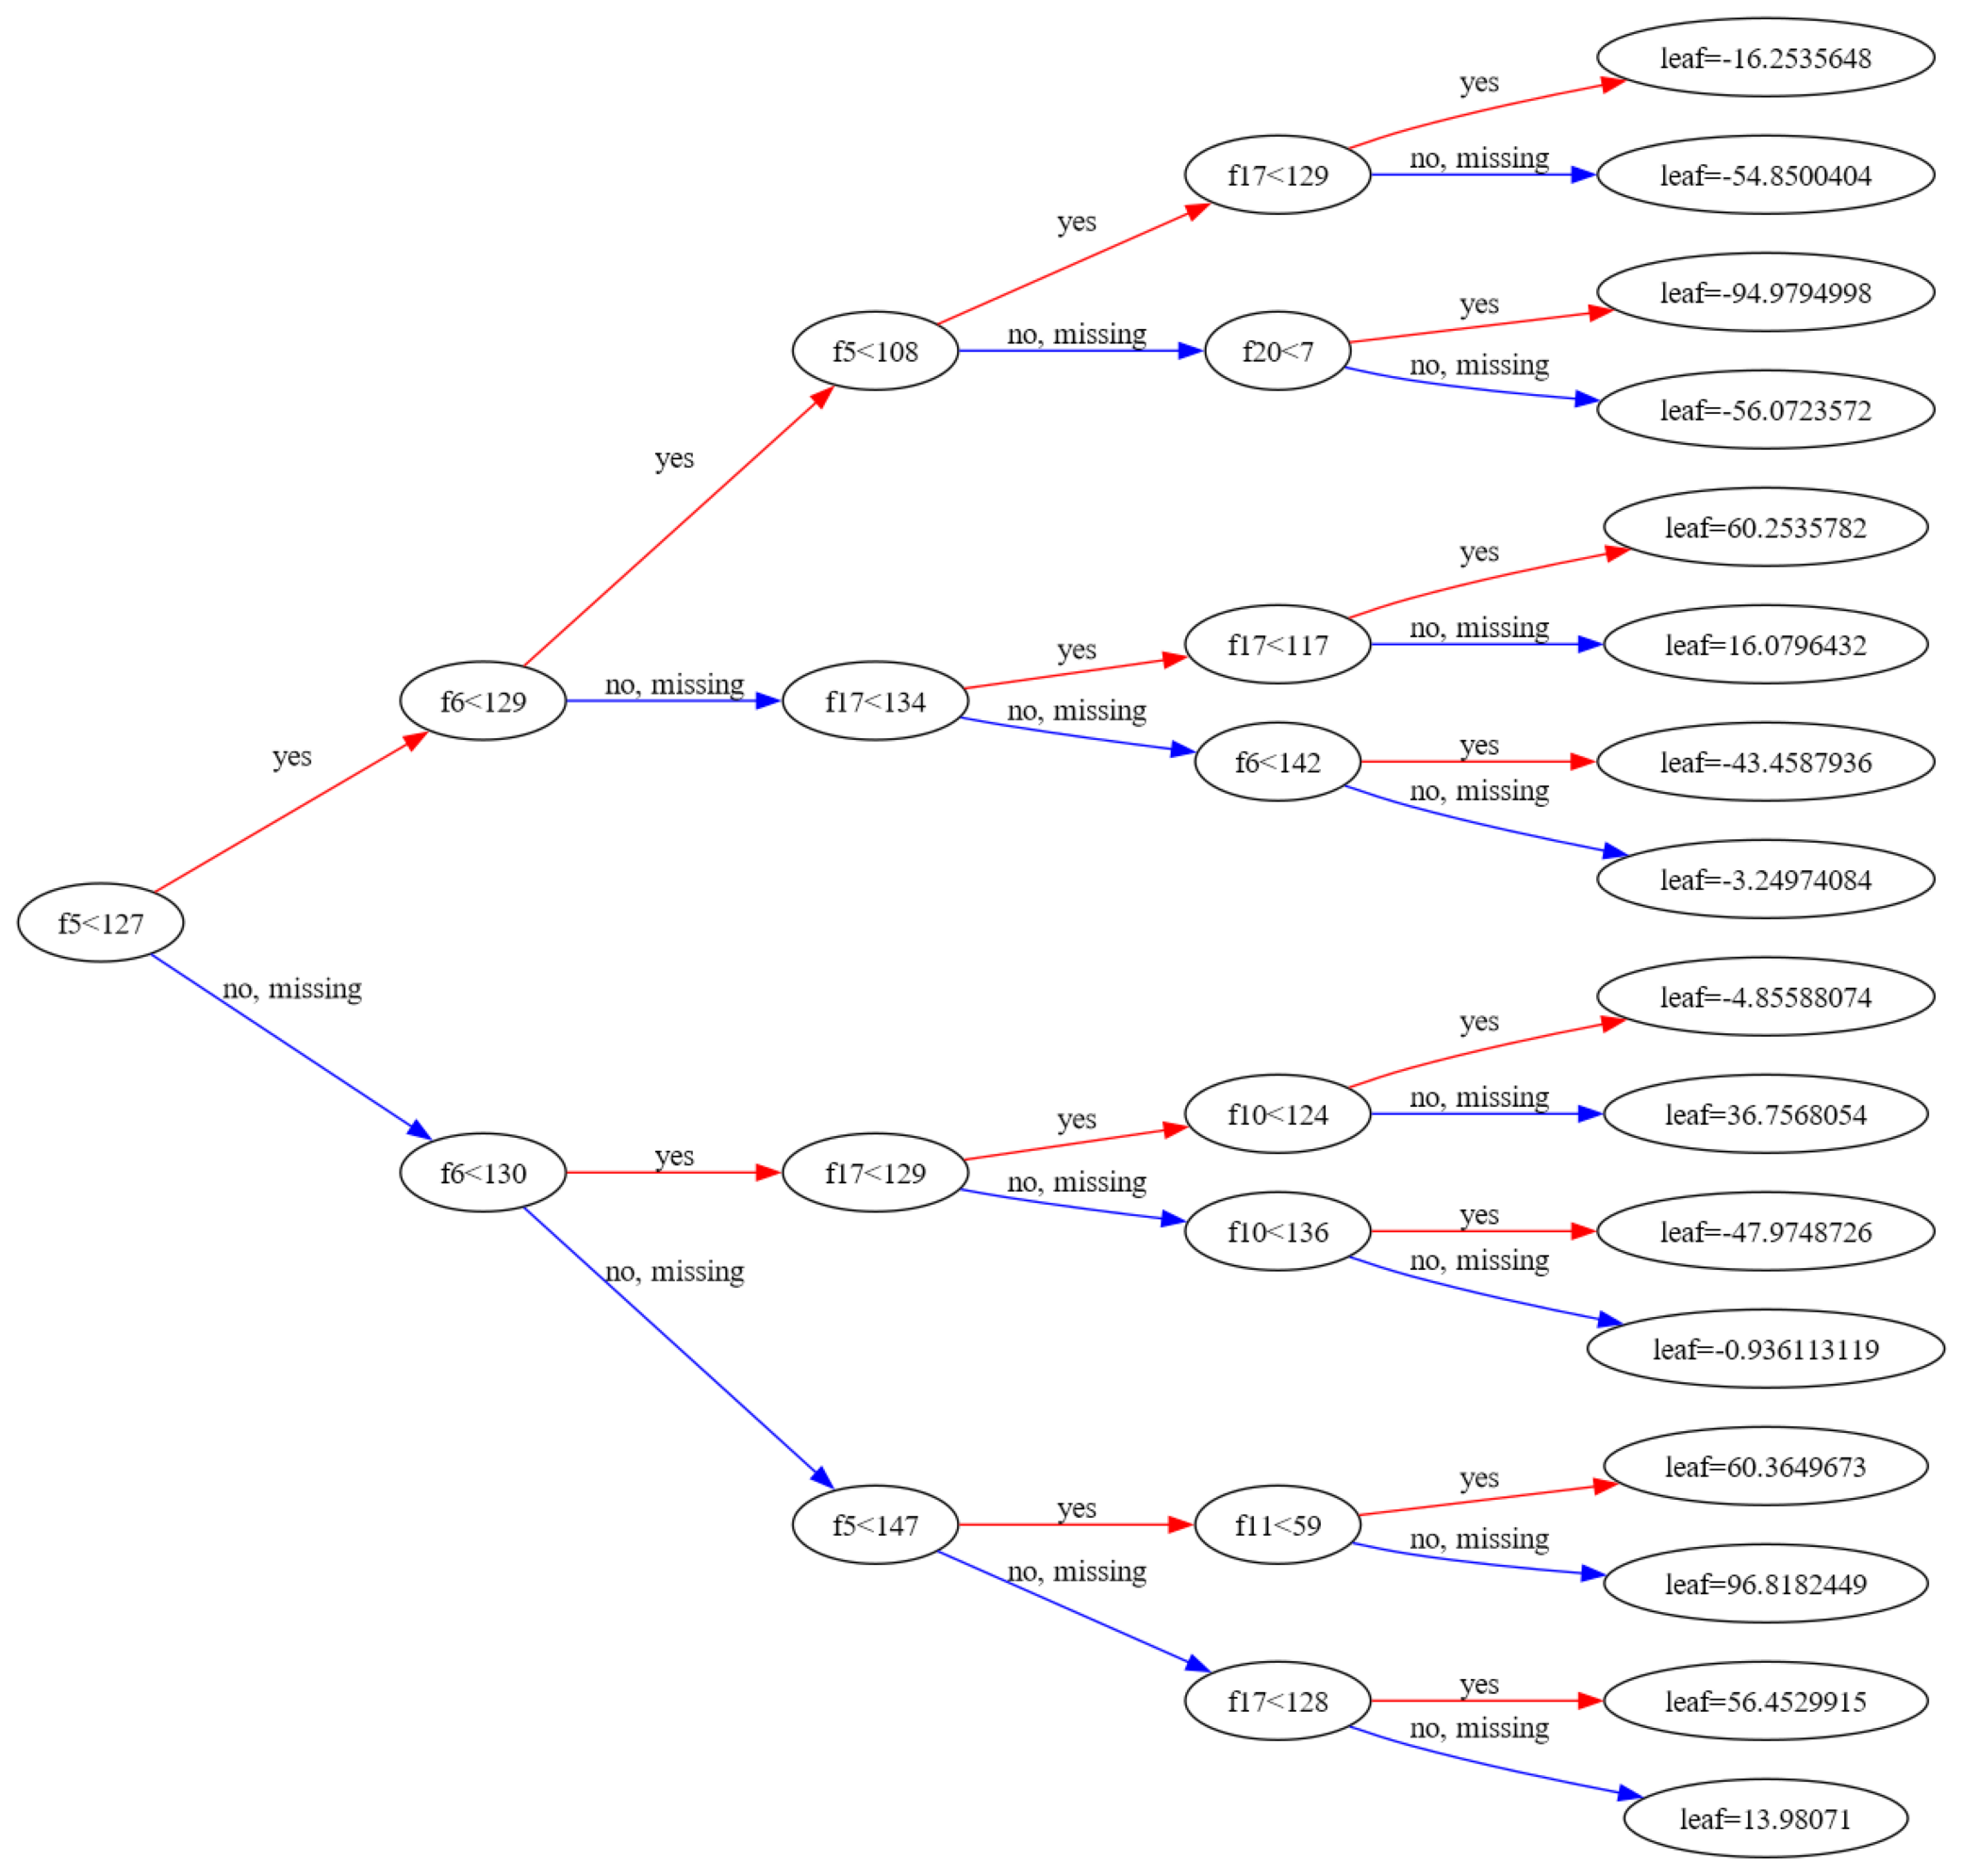

In [79]:
fig, ax = plt.subplots(figsize=(30, 20))
xgb.plot_tree(
    experiment.model, num_trees=0, ax=ax, rankdir="LR"
)  # LR for left to right direction
plt.tight_layout()
plt.savefig("first_tree.png", dpi=500)
plt.show()

# Model Performance

In [80]:
mask_e = experiment.testing_dataset.physics_object_type == "electron"
mask_p = experiment.testing_dataset.physics_object_type == "photon"
mask_pi0 = experiment.testing_dataset.physics_object_type == "pi0"
mask_pi_char = experiment.testing_dataset.physics_object_type == "pi_char"

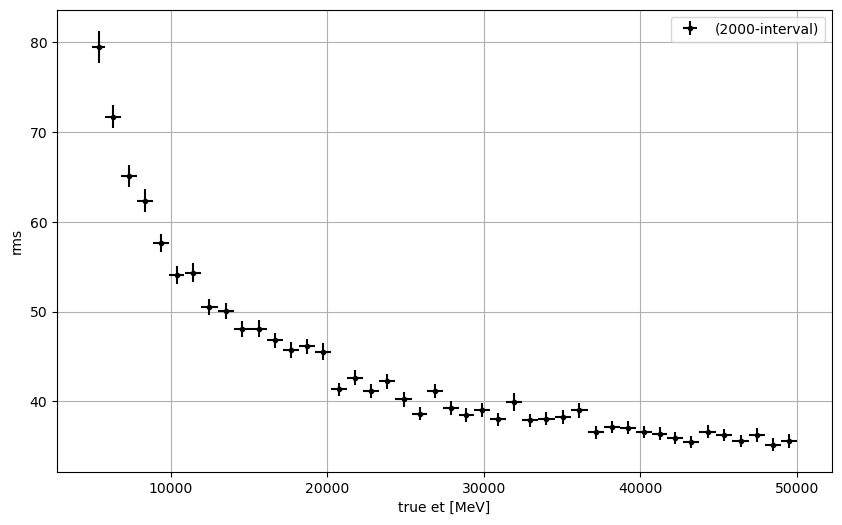

In [81]:
x_e, y_e, x_u_e, u_e = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_e],
    y_values=(experiment.y_test - experiment.y_pred)[mask_e],
    interval=2000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
)

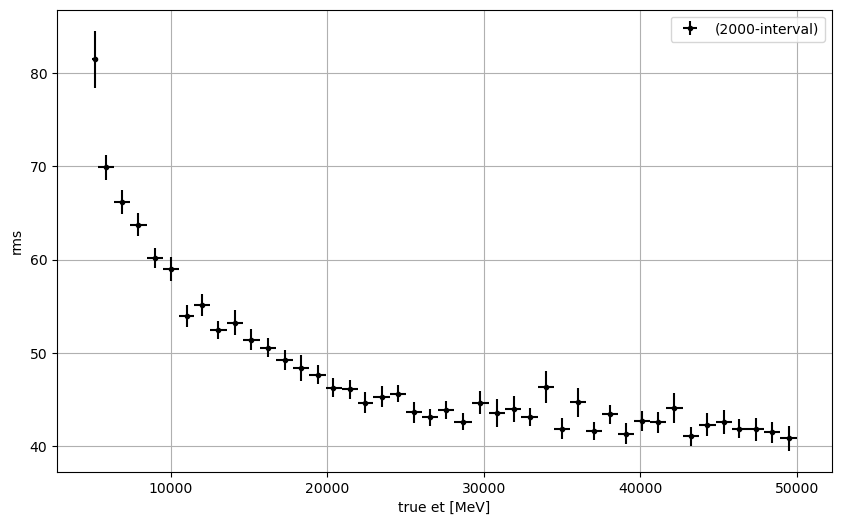

In [82]:
x_p, y_p, x_u_p, u_p = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_p],
    y_values=(experiment.y_test - experiment.y_pred)[mask_p],
    interval=2000,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
)

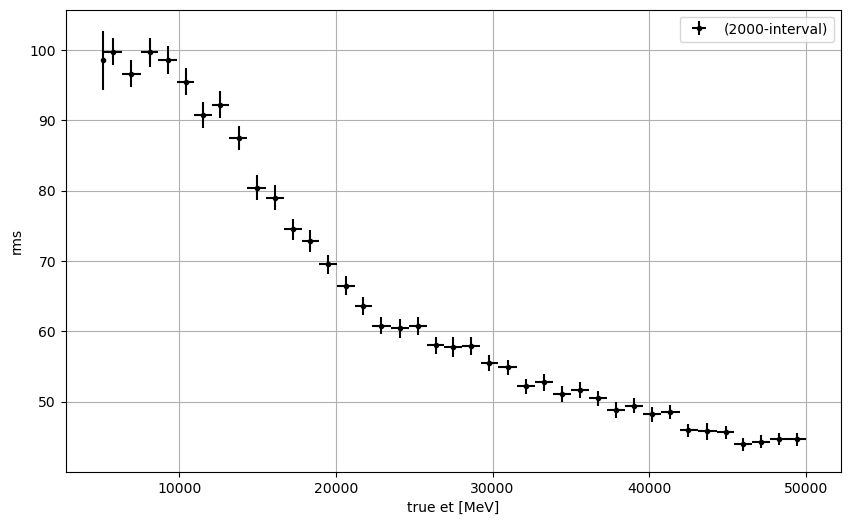

In [83]:
x_pi0, y_pi0, x_u_pi0, u_pi0 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi0],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi0],
    interval=2000,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
)

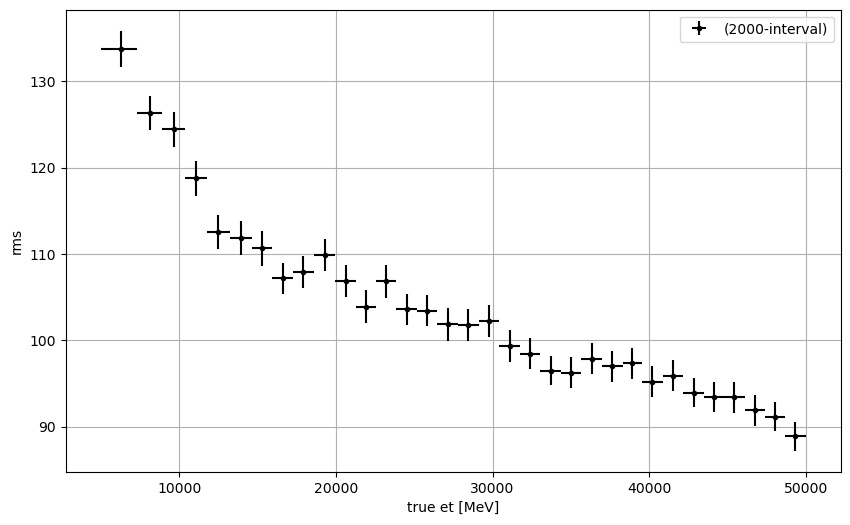

In [84]:
x_pi_char, y_pi_char, x_u_pi_char, u_pi_char = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi_char],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi_char],
    interval=2000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
)

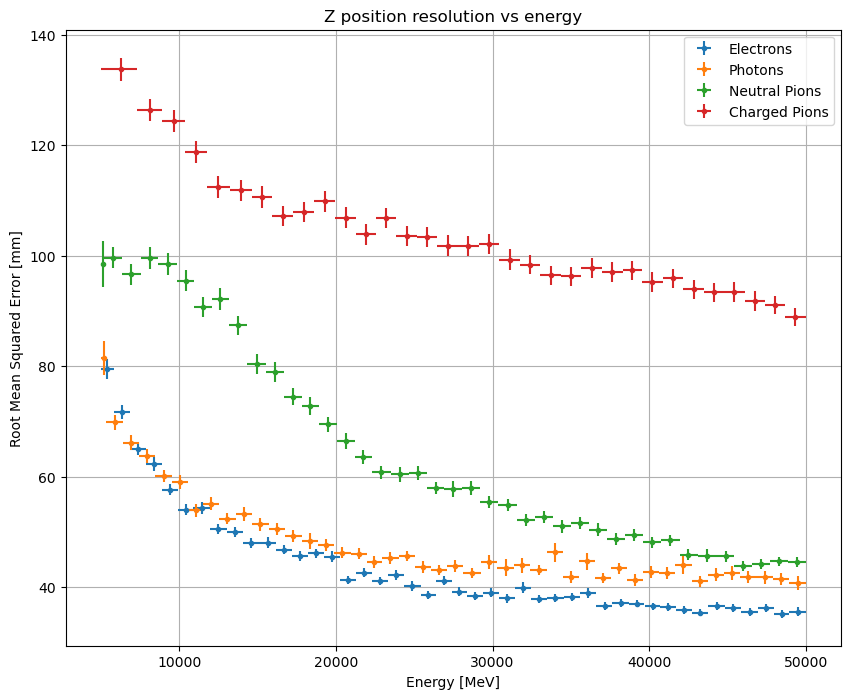

In [85]:
plt.figure(figsize=(10, 8))
plt.errorbar(x_e, y_e, xerr=x_u_e, yerr=u_e, fmt=".", label="Electrons")
plt.errorbar(x_p, y_p, xerr=x_u_p, yerr=u_p, fmt=".", label="Photons")
plt.errorbar(x_pi0, y_pi0, xerr=x_u_pi0, yerr=u_pi0, fmt=".", label="Neutral Pions")
plt.errorbar(
    x_pi_char,
    y_pi_char,
    xerr=x_u_pi_char,
    yerr=u_pi_char,
    fmt=".",
    label="Charged Pions",
)


# Adding labels and title
plt.xlabel("Energy [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Z position resolution vs energy")

plt.legend()
plt.grid()
plt.show()

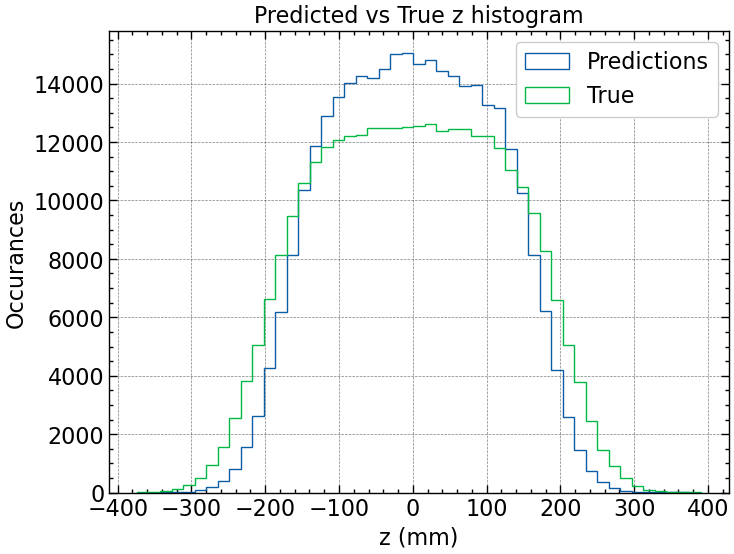

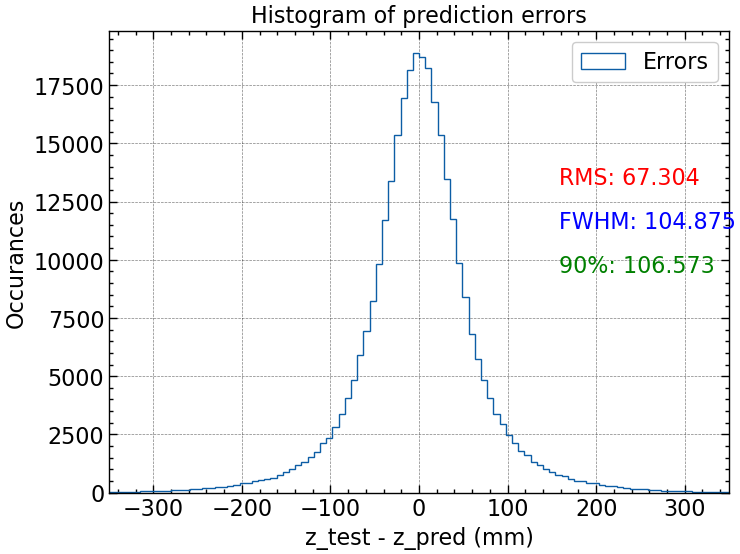

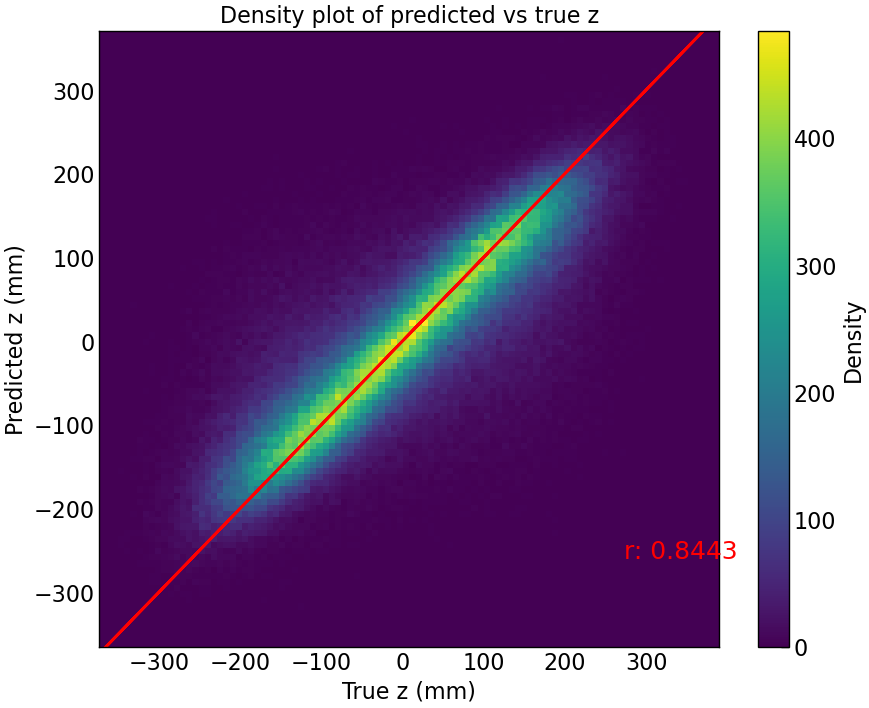

In [86]:
Y_test = experiment.y_test
Y_pred = experiment.y_pred
utils.plot_predictions(Y_test, Y_pred)

utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)

utils.plot_corelation(Y_test, Y_pred, density=True, log_density=False, plot_line=True)

In [87]:
experiment.X_train

array([[ 43, 339,  43, ..., 128,   0, 128],
       [ 56, 450,  57, ..., 128,   0, 128],
       [ 64, 503,  63, ..., 128,  23, 140],
       ...,
       [ 75, 595,  75, ..., 128,   0, 128],
       [ 31, 244,  31, ..., 128,   0, 128],
       [ 44, 356,  45, ..., 128,   0, 128]], dtype=int16)

In [88]:
np.sort(experiment.X_train.T[9])

array([  0,   0,   0, ..., 255, 255, 255], dtype=int16)

In [89]:
experiment.X_test

array([[ 23, 181,  23, ..., 128,   0, 128],
       [ 48, 378,  48, ..., 128,   0, 128],
       [ 79, 623,  78, ..., 128,   0, 128],
       ...,
       [ 16, 128,  16, ..., 128,   0, 128],
       [ 50, 398,  50, ..., 128,   0, 128],
       [ 43, 339,  43, ..., 128,   0, 128]], dtype=int16)

In [90]:
experiment.y_train

array([   3.238, -116.3  ,  126.4  , ...,   83.8  ,  -21.7  ,   -0.518],
      dtype=float16)

In [91]:
experiment.y_test

array([103.56 , -64.75 ,  -2.225, ..., 102.8  , -41.28 ,   3.238],
      dtype=float16)

# Shap for the Final Model

In [92]:
model = experiment.model
explainer = shap.TreeExplainer(model, check_additivity=False)

shap_values = explainer.shap_values(experiment.X_train, check_additivity=False)

[15:37:00] WARNING: D:\bld\xgboost-split_1705650032250\work\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


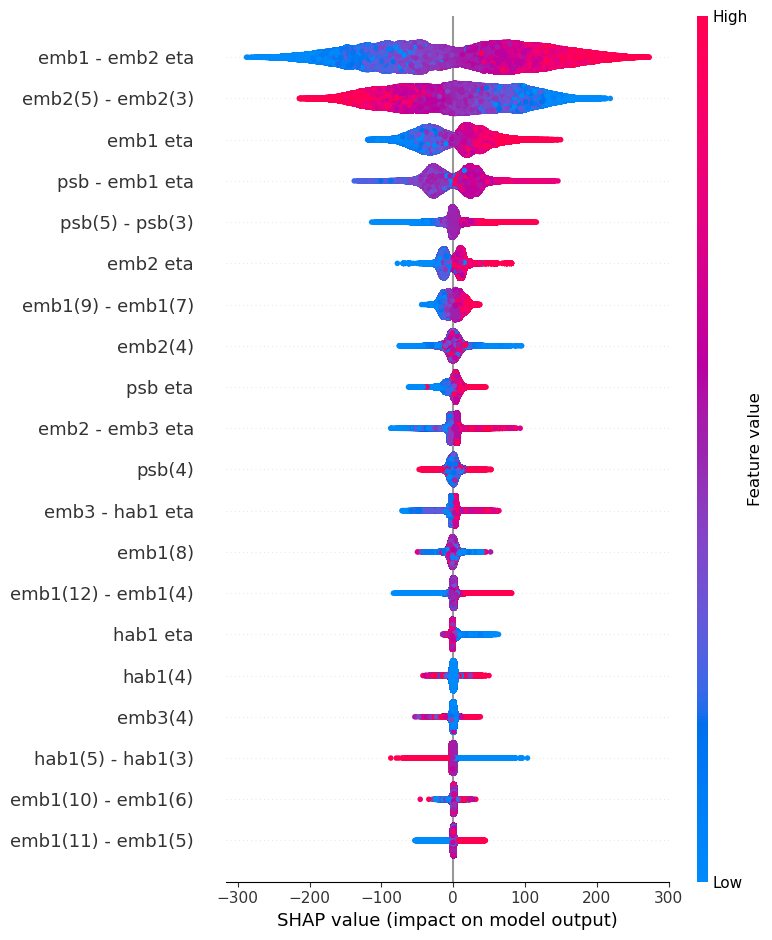

In [93]:
feature_names = [
    "psb eta",
    "emb1 eta",
    "emb2 eta",
    "emb3 eta",
    "hab1 eta",
    "psb - emb1 eta",
    "emb1 - emb2 eta",
    "emb2 - emb3 eta",
    "emb3 - hab1 eta",
    "psb(4)",
    "psb(5) - psb(3)",
    "emb1(8)",
    "emb1(9) - emb1(7)",
    "emb1(10) - emb1(6)",
    "emb1(11) - emb1(5)",
    "emb1(12) - emb1(4)",
    "emb2(4)",
    "emb2(5) - emb2(3)",
    "emb3(4)",
    "emb3(5) - emb3(3)",
    "hab1(4)",
    "hab1(5) - hab1(3)",
]


shap.summary_plot(shap_values, experiment.X_train, feature_names=feature_names)

In [94]:
x_plot1 = np.arange(-0.35, 0.35, 0.0001)

y_plot1 = np.array([q9.bin_function(val) for val in x_plot1])

Text(0.5, 1.0, ' Function quantising energy input (psb middle cell)')

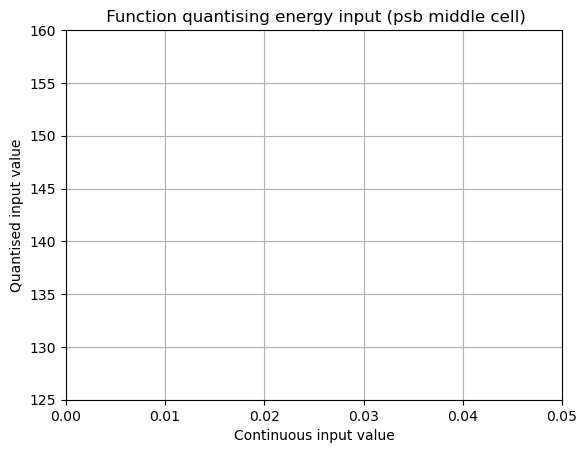

In [95]:
plt.plot(x_plot1, y_plot1)
plt.grid()
plt.xlim(0, 0.05)
plt.ylim(125, 160)
plt.xlabel("Continuous input value")
plt.ylabel("Quantised input value")
plt.title(" Function quantising energy input (psb middle cell)")

Text(0.5, 1.0, ' Function quantising energy input (psb middle cell)')

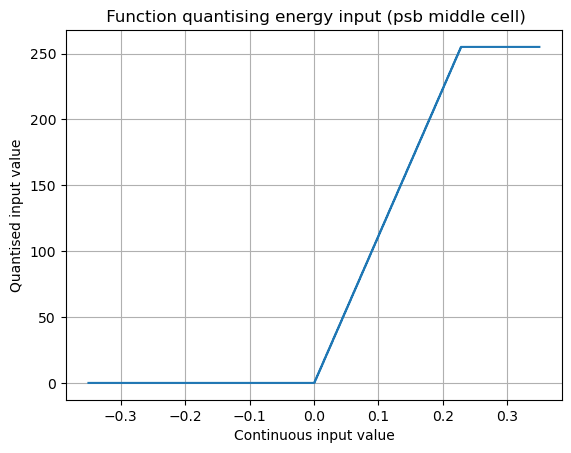

In [96]:
plt.plot(x_plot1, y_plot1)
plt.grid()
plt.xlabel("Continuous input value")
plt.ylabel("Quantised input value")
plt.title(" Function quantising energy input (psb middle cell)")

Text(0.5, 1.0, 'Function quantising psb - emb1 eta')

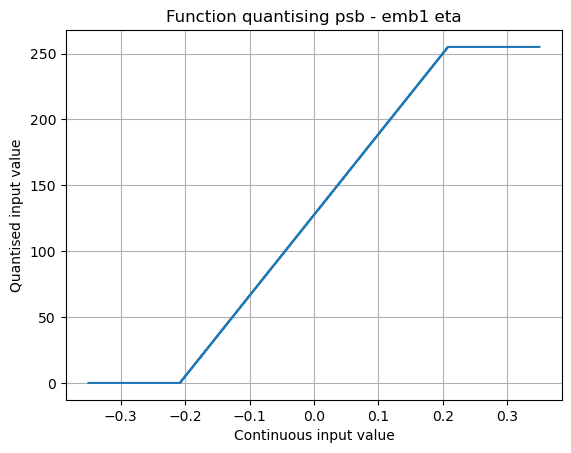

In [97]:
x_plot1 = np.arange(-0.35, 0.35, 0.0001)

y_plot1 = np.array([diff1_q.bin_function(val) for val in x_plot1])

plt.plot(x_plot1, y_plot1)
plt.grid()
plt.xlabel("Continuous input value")
plt.ylabel("Quantised input value")
plt.title("Function quantising psb - emb1 eta")

Text(0.5, 1.0, 'Function quantising psb - emb1 eta')

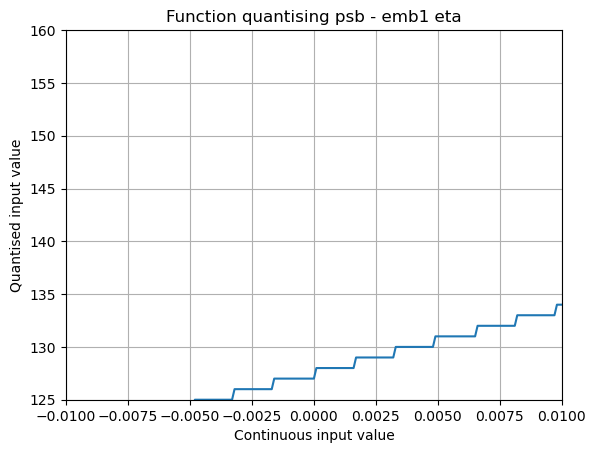

In [98]:
plt.plot(x_plot1, y_plot1)
plt.grid()
plt.xlim(-0.01, 0.01)
plt.ylim(125, 160)
plt.xlabel("Continuous input value")
plt.ylabel("Quantised input value")
plt.title("Function quantising psb - emb1 eta")

# Hyperparams scan tutaj